In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import statistics
import seaborn as sns
from skbio.stats.composition import multiplicative_replacement
from skbio.stats.composition import clr
from tqdm import tqdm

In [2]:
accTaxDictDF = pd.read_csv("./DataFiles/Dataframes/Master_Rename.csv").set_index("Bacterial_Strain")
accTaxDictDF['Species'] = accTaxDictDF['Species'].astype(str)
accTaxDictDF2 = accTaxDictDF.reset_index().set_index("Species").copy()
accTaxDictDF3 = accTaxDictDF2.loc[~accTaxDictDF2.index.duplicated(keep='first')].copy()

In [3]:
def inspectNodes(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append((accTaxDictDF3.at[i.replace(".","-"), 'Genus']))
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['American','Indian','European','Japanese'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[df2['Cohort']==i].dropna().index:
            tempDF.at[str(accTaxDictDF3.at[x.replace(".","-"), 'Genus']), i] += 1
            
    tempDF['American'] = tempDF[['American']].div(tempDF[['American']].sum())
    tempDF['Indian'] = tempDF[['Indian']].div(tempDF[['Indian']].sum())
    tempDF['European'] = tempDF[['European']].div(tempDF[['European']].sum())
    tempDF['Japanese'] = tempDF[['Japanese']].div(tempDF[['Japanese']].sum())
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

In [4]:
def inspectNodesGenusCount(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append((accTaxDictDF3.at[i.replace(".","-"), 'Genus']))
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['American','Indian','European','Japanese'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[i].dropna().index:
            tempDF.at[str(accTaxDictDF3.at[x.replace(".","-"), 'Genus']), i] += 1
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

In [5]:
def inspectNodesSpecies(df):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append(i)
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['American','Indian','European','Japanese'])
    tempDF.fillna(0, inplace=True)

    for i in tempDF.columns:
        for x in df2[df2['Cohort']==i].dropna().index:
            tempDF.at[str(x), i] += 1
    
    orderList = sorted(list(tempDF.index))
    
    tempDF2 = tempDF.loc[orderList].T.copy()
            
    return (tempDF2)

## Import Functional Potential DataFrame

In [6]:
americanSF_tigr = pd.read_csv("./DataFiles/Dataframes/functionalAnalysis/americanSpecies_TIGRFAMs.csv").rename(columns={'Unnamed: 0':'Bacterial_Species'}).set_index('Bacterial_Species')
indianSF_tigr = pd.read_csv("./DataFiles/Dataframes/functionalAnalysis/indianSpecies_TIGRFAMs.csv").rename(columns={'Unnamed: 0':'Bacterial_Species'}).set_index('Bacterial_Species')
europeanSF_tigr = pd.read_csv("./DataFiles/Dataframes/functionalAnalysis/europeanSpecies_TIGRFAMs.csv").rename(columns={'Unnamed: 0':'Bacterial_Species'}).set_index('Bacterial_Species')
japaneseSF_tigr = pd.read_csv("./DataFiles/Dataframes/functionalAnalysis/japaneseSpecies_TIGRFAMs.csv").rename(columns={'Unnamed: 0':'Bacterial_Species'}).set_index('Bacterial_Species')

## Load Node DataFrames for Component Networks

In [7]:
americanNodeDF = pd.read_csv("./DataFiles/GGM/NodeDataFrames/american_nodes.csv").set_index("Bacterial_Species").sort_values(by='Degree_Centrality', ascending=False)
indianNodeDF = pd.read_csv("./DataFiles/GGM/NodeDataFrames/indian_nodes.csv").set_index("Bacterial_Species").sort_values(by='Degree_Centrality', ascending=False)
europeanNodeDF = pd.read_csv("./DataFiles/GGM/NodeDataFrames/european_nodes.csv").set_index("Bacterial_Species").sort_values(by='Degree_Centrality', ascending=False)
japaneseNodeDF = pd.read_csv("./DataFiles/GGM/NodeDataFrames/japanese_nodes.csv").set_index("Bacterial_Species").sort_values(by='Degree_Centrality', ascending=False)

In [8]:
allNodeDF = pd.concat([americanNodeDF, indianNodeDF,europeanNodeDF, japaneseNodeDF]).copy()

In [9]:
americanNetwork = nx.read_gexf("./DataFiles/GGM/Networks/americanNetwork.gexf")
indianNetwork = nx.read_gexf("./DataFiles/GGM/Networks/indianNetwork.gexf")
europeanNetwork = nx.read_gexf("./DataFiles/GGM/Networks/europeanNetwork.gexf")
japaneseNetwork = nx.read_gexf("./DataFiles/GGM/Networks/japaneseNetwork.gexf")

## View Hub/Bottleneck Potential Keystone Species

In [10]:
americanPartitions_temp = set(line.strip() for line in open('./DataFiles/GGM/americanPartitions.txt'))
indianPartitions_temp = set(line.strip() for line in open('./DataFiles/GGM/indianPartitions.txt'))
europeanPartitions_temp = set(line.strip() for line in open('./DataFiles/GGM/europeanPartitions.txt'))
japanesePartitions_temp = set(line.strip() for line in open('./DataFiles/GGM/japanesePartitions.txt'))

americanPartitions = []
indianPartitions = []
europeanPartitions = []
japanesePartitions = []

for x in americanPartitions_temp:
    if (len(x.split(","))) >= 3:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        americanPartitions.append(tempSet)    
        
for x in indianPartitions_temp:
    if (len(x.split(","))) >= 3:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        indianPartitions.append(tempSet)  
        
for x in europeanPartitions_temp:
    if (len(x.split(","))) >=3:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        europeanPartitions.append(tempSet)  
        
for x in japanesePartitions_temp:
    if (len(x.split(","))) >= 3:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        japanesePartitions.append(tempSet)  

In [11]:
#This finds the Hub species within each network module with a negative degree assortativity
def dfModuleTop(df, network,partitions,chosenColumn):
    df2 = df.copy()
    TopDogs = []

    for i in partitions:
        if len(i) > 2:
        
            G = network.subgraph(i)
            
            
            tempDict = nx.degree_centrality(G)
                
            tempHold = []
            currentLeader = 'none'
            currentGoal = 0.0
                
            for x,y in tempDict.items():
                if y > currentGoal:
                    tempHold.append(x)
                    currentGoal = y
                        
                elif y == currentGoal:
                    tempHold.append(x)
                    currentGoal = y
                        
                else:
                    continue
                        
                
            if len(tempHold) > 1:
                topDOOG = df2.loc[tempHold].sort_values(by=chosenColumn, ascending=False).index[0]
                TopDogs.append(topDOOG)
            else:
                TopDogs = TopDogs + tempHold
    
    return(df2.loc[TopDogs])

In [12]:
# Look at the Degree Assortativity of each network module. Perfectly assortative (1 will show as nan)
def dfModuleTop_hub(network,partitions,cohort):
    
    tempdict = {"Module":[],"Degree_Assortativity":[],"Cohort":[]}
    for i in partitions:
        G = network.subgraph(i)
        tempdict['Module'].append(i)
        tempdict['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
        tempdict['Cohort'].append(cohort)
        
    tempdf = pd.DataFrame(data=tempdict)
    return tempdf                

In [13]:
japaneseMDA = dfModuleTop_hub(japaneseNetwork,japanesePartitions,"Japanese")

/home/mark/anaconda3/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [14]:
europeanMDA = dfModuleTop_hub(europeanNetwork,europeanPartitions,'European')

/home/mark/anaconda3/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [15]:
americanMDA = dfModuleTop_hub(americanNetwork,americanPartitions,'American')

/home/mark/anaconda3/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [16]:
indianMDA = dfModuleTop_hub(indianNetwork,indianPartitions,'Indian')

/home/mark/anaconda3/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [17]:
allMDA = pd.concat([japaneseMDA,europeanMDA,americanMDA,indianMDA]).dropna()
allMDA.head()

,Module,Degree_Assortativity,Cohort
0,"[Blautia_obeum, Ruminococcus_torques, Eubacter...",-0.216167,Japanese
1,"[Coprobacter_fastidiosus, Paraprevotella_xylan...",-0.200000,Japanese
2,"[Bacteroides_thetaiotaomicron, Bacteroides_ste...",-0.328418,Japanese
3,"[Clostridium_innocuum, Oscillibacter_sp_PEA192...",0.014608,Japanese
4,"[Bacteroides_pyogenes, Bacteroides_nordii, But...",-0.666667,Japanese


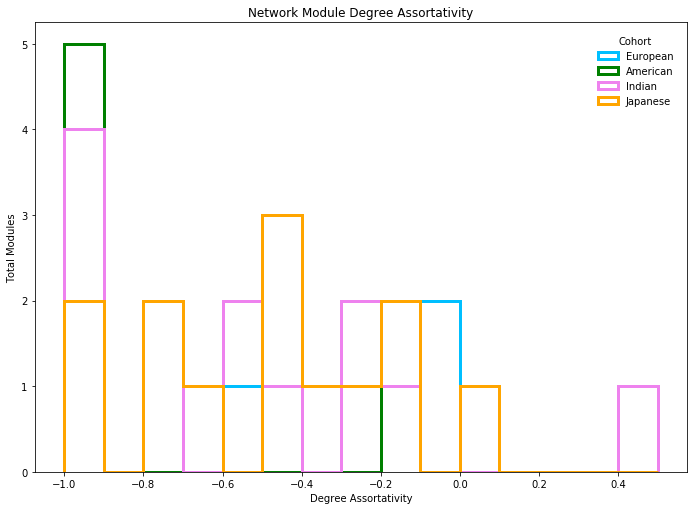

In [18]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

palette ={"American":'green', "European":'deepskyblue', "Indian":'violet', "Japanese":'orange'}


#sns.set_palette(palette=palette.values())
for Cohort in set(allMDA['Cohort']):
    subset = allMDA[allMDA['Cohort'] == Cohort].copy()
    sns_hist = sns.distplot(subset['Degree_Assortativity'], color=palette[Cohort] ,hist = True, kde = False, bins=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5], label = Cohort, hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1})
    
# Plot formatting
plt.title('Network Module Degree Assortativity')
plt.xlabel('Degree Assortativity')
plt.ylabel('Total Modules')
plt.legend(loc=1, borderaxespad=1,framealpha=1, edgecolor='white', facecolor='white',title='Cohort')
plt.show()
fig = sns_hist.get_figure()
plt.show()

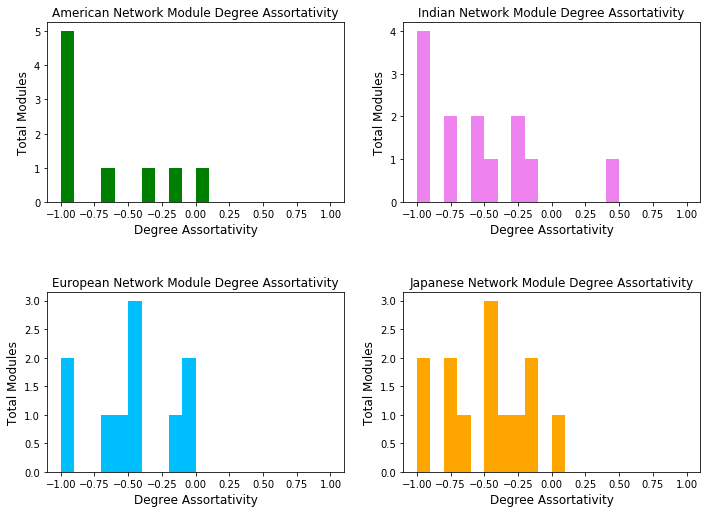

In [19]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(list(allMDA[allMDA['Cohort']=='American']['Degree_Assortativity']),color=palette['American'],bins=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,.6,.7,.8,.9,1])
axs[0, 1].hist(list(allMDA[allMDA['Cohort']=='Indian']['Degree_Assortativity']), color=palette['Indian'],bins=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,.6,.7,.8,.9,1])
axs[1, 0].hist(list(allMDA[allMDA['Cohort']=='European']['Degree_Assortativity']), color=palette['European'],bins=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,.6,.7,.8,.9,1])
axs[1, 1].hist(list(allMDA[allMDA['Cohort']=='Japanese']['Degree_Assortativity']), color=palette['Japanese'],bins=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,.6,.7,.8,.9,1])


axs[0, 0].set_title("American Network Module Degree Assortativity", size=12)
axs[0, 0].set_xlabel('Degree Assortativity', size=12)
axs[0, 0].set_ylabel('Total Modules', size=12)

axs[0, 1].set_title("Indian Network Module Degree Assortativity", size=12)
axs[0, 1].set_xlabel('Degree Assortativity', size=12)
axs[0, 1].set_ylabel('Total Modules', size=12)

axs[1, 0].set_title("European Network Module Degree Assortativity", size=12)
axs[1, 0].set_xlabel('Degree Assortativity', size=12)
axs[1, 0].set_ylabel('Total Modules', size=12)

axs[1, 1].set_title("Japanese Network Module Degree Assortativity", size=12)
axs[1, 1].set_xlabel('Degree Assortativity', size=12)
axs[1, 1].set_ylabel('Total Modules', size=12)

fig.subplots_adjust(hspace=.5)
plt.show()

## FIND MODULE SPECIES

In [20]:
#Find Hub species in each Module
#jComNodeDF2 = dfModuleTop(japaneseNodeDF,japaneseNetwork,japanesePartitions,'Degree_Centrality')
#eComNodeDF2 = dfModuleTop(europeanNodeDF,europeanNetwork,europeanPartitions,'Degree_Centrality')
#iComNodeDF2 = dfModuleTop(indianNodeDF,indianNetwork,indianPartitions,'Degree_Centrality')
#aComNodeDF2 = dfModuleTop(americanNodeDF,americanNetwork,americanPartitions,'Degree_Centrality')

#allDegComNodesDF2 = pd.concat([jComNodeDF2,eComNodeDF2,iComNodeDF2,aComNodeDF2])
allDegComNodesDF2 = pd.read_csv("./DataFiles/Dataframes/HubNodes.csv").set_index("Bacterial_Species")
allDegComNodesDF2.head()

,Mean_Relative_Abundance,Total_Edges,Positive_Edges,Negative_Edges,Triangles,Degree_Centrality,Clustering_Coefficient,Harmonic_Centrality,Betweenness_Centrality,Cohort
Bacterial_Species,,,,,,,,,,
Prevotella_copri,0.059441,3,3,0,0,0.014925,0.000000,3.000000,0.000149,Japanese
Bacteroides_salanitronis,0.000922,6,6,0,4,0.029851,0.266667,26.786905,0.020920,Japanese
Alistipes_timonensis,0.000281,2,2,0,0,0.009950,0.000000,2.500000,0.000100,Japanese
Oscillibacter_ruminantium,0.000040,7,2,5,8,0.034826,0.380952,36.327381,0.017869,Japanese
Lachnospiraceae_bacterium_Choco86,0.000741,14,13,1,38,0.069652,0.417582,35.977381,0.012519,Japanese


In [21]:
##HUBS
ComDegSpeciesModules = inspectNodesSpecies(allDegComNodesDF2)
ComDegGeneraModules = inspectNodes(allDegComNodesDF2)

In [22]:
#ComDegSpeciesModules.to_csv("./DataFiles/GGM/highDegreeSpecies")

## Visualize

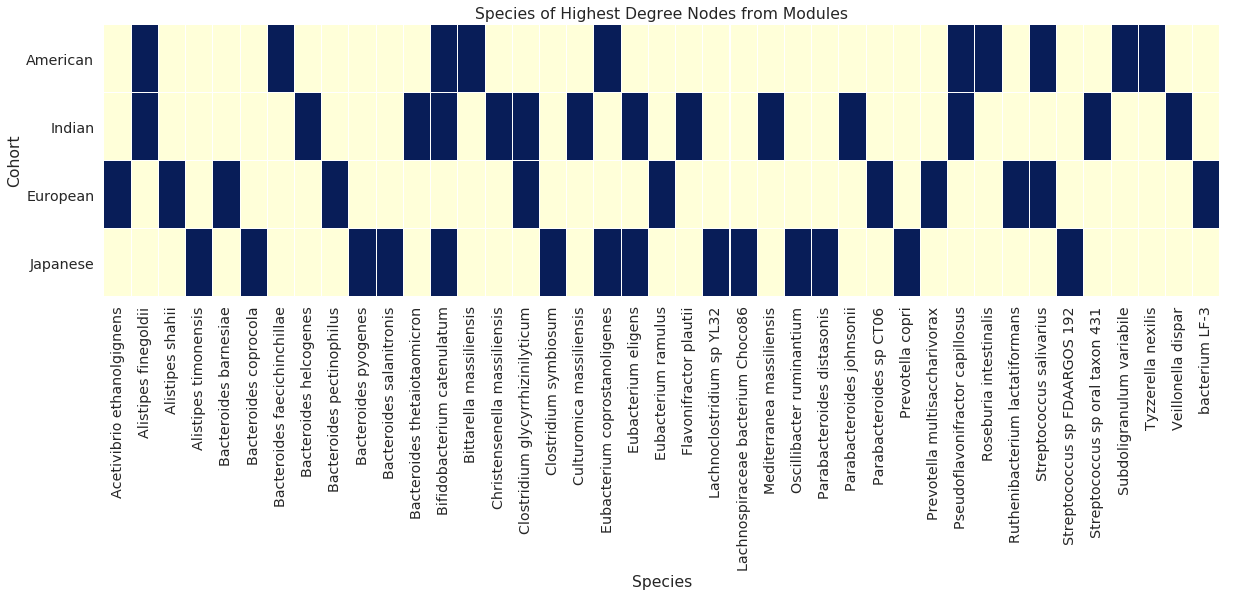

In [65]:
fig, ax = plt.subplots(figsize=(20,5))
for indexName3 in ComDegSpeciesModules.columns:
        ComDegSpeciesModules.rename(columns={indexName3:indexName3.replace("_"," ")}, inplace=True)
sns.heatmap(ComDegSpeciesModules, annot=False,xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, cbar=False, cmap="YlGnBu")
plt.title("Species of Highest Degree Nodes from Modules")
plt.ylabel("Cohort")
plt.xlabel("Species")
plt.yticks(rotation=0)
plt.show()

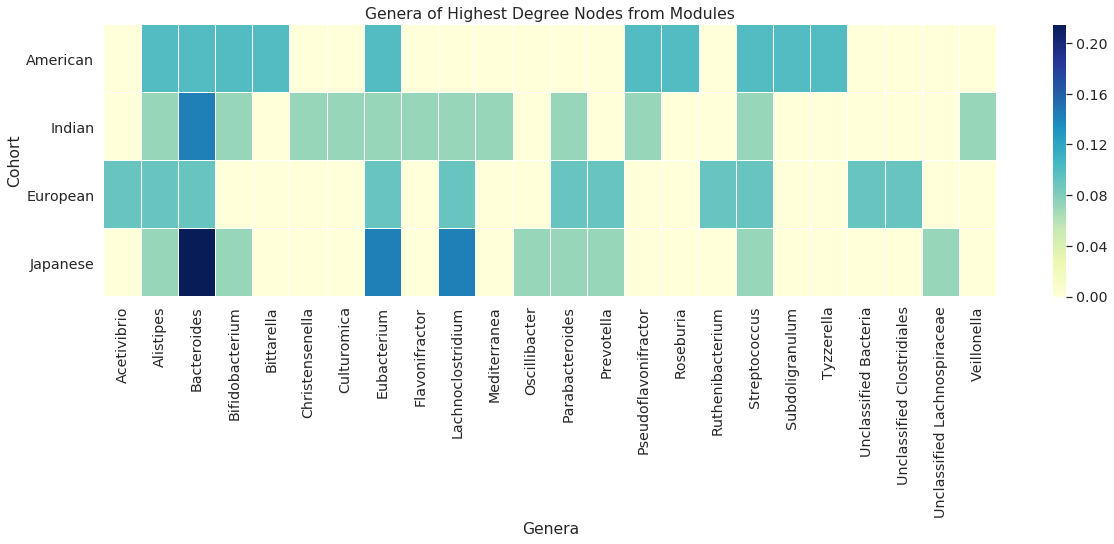

In [66]:
fig, ax = plt.subplots(figsize=(20,5))

for indexName3 in ComDegGeneraModules.columns:
        ComDegGeneraModules.rename(columns={indexName3:indexName3.replace("_"," ")}, inplace=True)
        
sns.heatmap(ComDegGeneraModules, annot=False,xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, cmap="YlGnBu")
plt.title("Genera of Highest Degree Nodes from Modules")
plt.ylabel("Cohort")
plt.xlabel("Genera")
plt.yticks(rotation=0)
plt.show()

## BOTTLENECKS

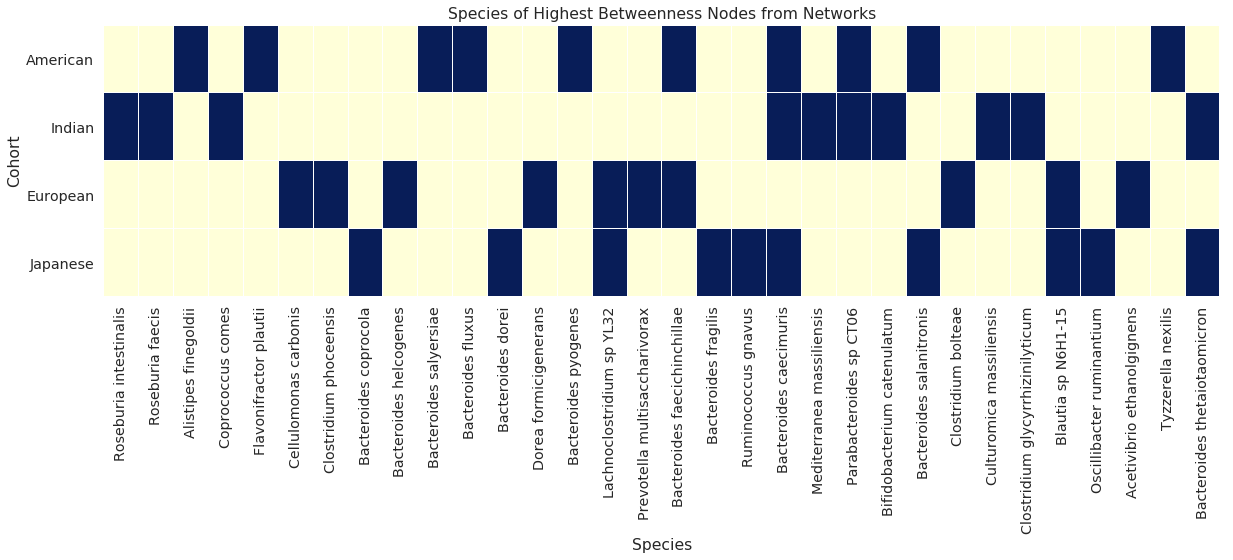

In [69]:
betSet = set(list(japaneseNodeDF.sort_values(by='Betweenness_Centrality', ascending=False).head(10).index) + list(europeanNodeDF.sort_values(by='Betweenness_Centrality', ascending=False).head(10).index) + list(indianNodeDF.sort_values(by='Betweenness_Centrality', ascending=False).head(10).index) + list(americanNodeDF.sort_values(by='Betweenness_Centrality', ascending=False).head(10).index))
betNetDF = pd.DataFrame(index=betSet, columns=['American','Indian','European','Japanese']).fillna(0)
for cohort in betNetDF.columns:
    if cohort == 'American':
        for x in list(americanNodeDF.sort_values(by='Betweenness_Centrality', ascending=False).head(10).index):
            betNetDF.at[x,cohort] +=1
            
    elif cohort == 'Indian':
        for x in list(indianNodeDF.sort_values(by='Betweenness_Centrality', ascending=False).head(10).index):
            betNetDF.at[x,cohort] +=1

    elif cohort == 'European':
        for x in list(europeanNodeDF.sort_values(by='Betweenness_Centrality', ascending=False).head(10).index):
            betNetDF.at[x,cohort] +=1

    else:
        for x in list(japaneseNodeDF.sort_values(by='Betweenness_Centrality', ascending=False).head(10).index):
            betNetDF.at[x,cohort] +=1

fig, ax = plt.subplots(figsize=(20,5))

betNetDF2 = betNetDF.copy()
for indexName3 in betNetDF.index:
        betNetDF.rename(index={indexName3:indexName3.replace("_"," ")}, inplace=True)
        
sns.heatmap(betNetDF.T, annot=False,xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, cbar=False, cmap="YlGnBu")
plt.title("Species of Highest Betweenness Nodes from Networks")
plt.ylabel("Cohort")
plt.xlabel("Species")
plt.yticks(rotation=0)
plt.show()

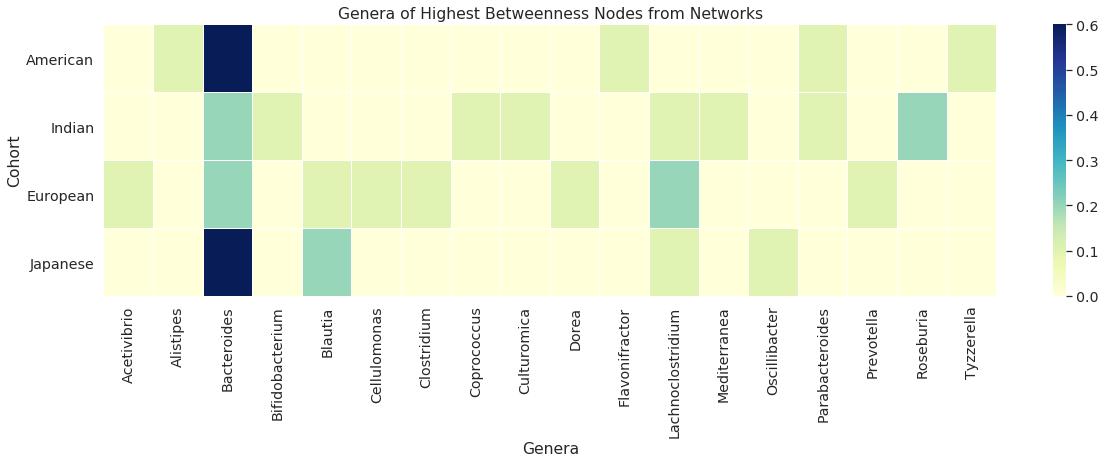

In [68]:
betNetDF2.replace(0,np.nan, inplace=True)
betNetDF2.head()
betNetGenera = inspectNodesGenusCount(betNetDF2)
betNetGenera2 = betNetGenera.div(betNetGenera.sum(axis=1), axis=0).copy()            


fig, ax = plt.subplots(figsize=(20,5))

for indexName in betNetGenera2.index:
        betNetGenera2.rename(index={indexName:indexName.replace("_"," ")}, inplace=True)
        
sns.heatmap(betNetGenera2, annot=False,xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, cmap="YlGnBu")
plt.title("Genera of Highest Betweenness Nodes from Networks")
plt.ylabel("Cohort")
plt.xlabel("Genera")
plt.yticks(rotation=0)
plt.show()

## GRAB THE CORRECT SPECIES FUNCTIONALITY

In [27]:
def buildFunctionalDF_TIGRFAM(df, bacteriaType):
    
    df2 = df.copy()
    
    for cohort in set(list(df['Cohort'])):
        
        testList= [x for x in df[df['Cohort']==cohort].index]
                
        if cohort == 'American':
            tempdf1 = americanSF_tigr.loc[testList].copy()
            tempdf1['Cohort'] = 'American'
                
        elif cohort == 'Indian':
            tempdf2 = indianSF_tigr.loc[testList].copy()
            tempdf2['Cohort'] = 'Indian'
        
        elif cohort == 'European':
            tempdf3 = europeanSF_tigr.loc[testList].copy()
            tempdf3['Cohort'] = 'European'
        
        elif cohort == 'Japanese':
            tempdf4 = japaneseSF_tigr.loc[testList].copy()
            tempdf4['Cohort'] = 'Japanese'
            
        else:
            continue

            
    newPfam = pd.concat([tempdf1, tempdf2, tempdf3,tempdf4]).copy()

    newPfam['Designation'] = bacteriaType
    
    return newPfam 

In [28]:
def buildFunctionalDF_TIGRFAM2(df):
    
    df2 = df.copy()
    
    for cohort in set(list(df['Cohort'])):
        
        testList= [x for x in df[df['Cohort']==cohort].index]
                
        if cohort == 'American':
            tempdf1 = americanSF_tigr.loc[testList].copy()
            tempdf1['Cohort'] = 'American'
            tempdf1['Designation'] =  [x for x in df2[df2['Cohort']==cohort]['Designation']]
                
        elif cohort == 'Indian':
            tempdf2 = indianSF_tigr.loc[testList].copy()
            tempdf2['Cohort'] = 'Indian'
            tempdf2['Designation'] =  [x for x in df2[df2['Cohort']==cohort]['Designation']]
        
        elif cohort == 'European':
            tempdf3 = europeanSF_tigr.loc[testList].copy()
            tempdf3['Cohort'] = 'European'
            tempdf3['Designation'] =  [x for x in df2[df2['Cohort']==cohort]['Designation']]
        
        elif cohort == 'Japanese':
            tempdf4 = japaneseSF_tigr.loc[testList].copy()
            tempdf4['Cohort'] = 'Japanese'
            tempdf4['Designation'] =  [x for x in df2[df2['Cohort']==cohort]['Designation']]
            
        else:
            continue

            
    newPfam = pd.concat([tempdf1, tempdf2, tempdf3,tempdf4]).copy()
    
    return newPfam 

## Build full community nodes

In [29]:
def labelModules(partition, cohort):
    tempDict = {}
    countt = 0
    for i in partition:
        tempDict[cohort+"_Module_"+str(countt)] = i
        countt +=1
        
    return (tempDict)

In [30]:
americanModuleLabel = labelModules(americanPartitions, "American")
indianModuleLabel = labelModules(indianPartitions, "Indian")
europeanModuleLabel = labelModules(europeanPartitions, "European")
japaneseModuleLabel = labelModules(japanesePartitions, "Japanese")

In [31]:
import json
with open('./DataFiles/GGM/americanModuleLabels.json', 'w') as fpa:
    json.dump(americanModuleLabel, fpa)
    
with open('./DataFiles/GGM/indianModuleLabels.json', 'w') as fpi:
    json.dump(indianModuleLabel, fpi)
    
with open('./DataFiles/GGM/europeanModuleLabels.json', 'w') as fpe:
    json.dump(europeanModuleLabel, fpe)

with open('./DataFiles/GGM/japaneseModuleLabels.json', 'w') as fpj:
    json.dump(japaneseModuleLabel, fpj)

In [32]:
def buildCommunityNodes(comList, cohortFunctionality, cohortName):
    
    tempDF = pd.DataFrame(columns=cohortFunctionality.columns)
    
    i = 0
    for module in list(comList.keys()):
        tempDF.loc[module] = cohortFunctionality.loc[comList[module]].sum().copy()
        i+=1
    
    tempDF['Cohort'] = cohortName
    
    return tempDF

In [33]:
americanModules = buildCommunityNodes(americanModuleLabel, americanSF_tigr, 'American')
indianModules = buildCommunityNodes(indianModuleLabel, indianSF_tigr, 'Indian')
europeanModules = buildCommunityNodes(europeanModuleLabel, europeanSF_tigr, 'European')
japaneseModules = buildCommunityNodes(japaneseModuleLabel, japaneseSF_tigr, 'Japanese')

In [34]:
allModules = pd.concat([americanModules,indianModules,europeanModules,japaneseModules ])
#Label the index so the PCA code doesnt have to be changed. Im lazy I know. 
allModules.index.name = 'Bacterial_Species'
allMDF1 = allModules.copy()
allMDF2 = allMDF1.drop(columns=['Cohort']).copy()
allMDF2.replace(0.0, np.nan, inplace=True)
allMDF2.dropna(axis=1, thresh=1, inplace=True)
allMDF2.fillna(0.0, inplace=True)
allMDF3 = allMDF2.copy()

for row in allMDF3.index:
    allMDF3.loc[row] = clr(np.array(allMDF2.loc[row].replace(0.0, 1e-10)))
allMDF3['Cohort'] = allMDF1['Cohort']
allMDF3.head()

,TIGR02778,TIGR00283,TIGR02100,TIGR02359,TIGR00224,TIGR00745,TIGR00260,TIGR04171,TIGR03819,TIGR01419,...,TIGR01673,TIGR02366,TIGR01919,TIGR01832,TIGR00100,TIGR01295,TIGR03494,TIGR01733,TIGR00967,Cohort
Bacterial_Species,,,,,,,,,,,,,,,,,,,,,
American_Module_0,-11.457902,-11.457902,4.771125,5.804750,8.424359,8.130302,8.241246,-11.457902,-11.457902,-11.457902,...,-11.457902,3.520843,-11.457902,-11.457902,5.932877,-11.457902,-11.457902,7.732213,8.424596,American
American_Module_1,-8.559897,7.626477,8.355151,9.075029,8.807405,9.061788,10.054659,-8.559897,-8.559897,-8.559897,...,-8.559897,8.726962,-8.559897,7.654709,-8.559897,-8.559897,-8.559897,-8.559897,9.741570,American
American_Module_2,-9.518060,-9.518060,7.337154,8.725481,8.704787,8.580210,9.059977,-9.518060,-9.518060,-9.518060,...,-9.518060,6.715446,-9.518060,-9.518060,-9.518060,-9.518060,-9.518060,9.481659,8.961949,American
American_Module_3,-5.886687,-5.886687,-5.886687,-5.886687,-5.886687,-5.886687,11.371535,11.371535,-5.886687,-5.886687,...,-5.886687,-5.886687,-5.886687,-5.886687,-5.886687,10.375734,-5.886687,11.371535,11.371535,American
American_Module_4,-4.510926,-4.510926,13.961113,-4.510926,-4.510926,12.853375,13.267966,12.853375,-4.510926,-4.510926,...,-4.510926,-4.510926,13.267966,-4.510926,-4.510926,-4.510926,-4.510926,-4.510926,13.267966,American


## Plot on PCA

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop("Cohort", axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={"American":'green', "European":'deepskyblue', "Indian":'violet', "Japanese":'orange'}

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')')

    targets = ['American','European','Indian', 'Japanese']

    colors = ['green','deepskyblue','violet','orange']
    
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Cohorts')
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.set(font_scale=1.5)
    plt.show()

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA2(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={"American":'green', "European":'deepskyblue', "Indian":'violet', "Japanese":'orange'}

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis ('+title+')', y=1.03)

    targets = ['American','European','Indian', 'Japanese']
    colors = ['green','deepskyblue','violet','orange']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50, alpha=.5)
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Cohorts')
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.set(font_scale=1.5)
    plt.show()

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullFeatureImportance(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    return (pd.DataFrame(pca.components_,columns=pcaDF3.columns,index = ['PC-1','PC-2']))

## Look at Feature Importance

In [38]:
def pullTopFeatures(df, pc):
    tempDictionary = {"TIGRFAM":[], "Feature_Importance":[]}
    df1 = df.copy()
    df2 = df1.T.reindex(featureImportanceDF_TIGRFAM.T[pc].abs().sort_values(ascending=False).index).copy()
    posCount = 0
    negCount = 0
    
    for row in df2.index:
        if df2.at[row,pc] > 0 and posCount < 10:
            tempDictionary["TIGRFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            posCount +=1
            
        elif df2.at[row,pc] < 0 and negCount < 10:
            tempDictionary["TIGRFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            negCount +=1
        
        else:
            continue
    
    tempDF = pd.DataFrame(data=tempDictionary)
    return(tempDF.set_index("TIGRFAM").sort_values(by="Feature_Importance", ascending=False))

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullNodeArea(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort","Designation"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort','Designation']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort','Designation']]], axis = 1).copy()
    
    tempDict = {"Bacterial_Species":[], "Cohort":[], "PC1":[], "PC2":[]}
    
    for x in finalDf.index:
        tempDict['Bacterial_Species'].append(list(dataframe.index)[x])
        tempDict['Cohort'].append(finalDf.at[x,'Cohort'])
        tempDict['PC1'].append(finalDf.at[x,'principal component 1'])
        tempDict['PC2'].append(finalDf.at[x,'principal component 2'])
    
    
    tempDF = pd.DataFrame(data=tempDict).set_index("Bacterial_Species")
    
    tempDict2 = {"Cohort":[], "LeftSide":[], "RightSide":[]}
    
    for y in list(set(tempDF['Cohort'])):
        tempDict2['Cohort'].append(y)
        tempDict2['LeftSide'].append(len([i for i in list(tempDF[tempDF["Cohort"]==y]['PC1']) if i < 0]))
        tempDict2['RightSide'].append(len([i for i in list(tempDF[tempDF["Cohort"]==y]['PC1']) if i > 0]))
    
    tempDF2 = pd.DataFrame(data=tempDict2).set_index("Cohort")
    
    return tempDF2

## Look at Clusters on the PCA Below This

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullNodeModuleArea(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("Bacterial_Species",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    tempDict = {"Bacterial_Species":[], "PC1":[], "PC2":[]}
    
    for x in finalDf.index:
        tempDict['Bacterial_Species'].append(list(dataframe.index)[x])
        tempDict['PC1'].append(finalDf.at[x,'principal component 1'])
        tempDict['PC2'].append(finalDf.at[x,'principal component 2'])
    
    tempDF = pd.DataFrame(data=tempDict).set_index("Bacterial_Species")

    tempDict2 = {"Module":[], "Left_Cluster":[], "Right_Cluster":[], "Top_Cluster":[], "Bottom_Cluster":[]}
    
    for y in tempDF.index:
        tempDict2['Module'].append(y)
        if float(tempDF.at[y,'PC2']) > 100:
            tempDict2['Top_Cluster'].append(1)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) < 50 and float(tempDF.at[y,'PC1']) < -90: 
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(1)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(np.nan)
        elif float(tempDF.at[y,'PC2']) < -80 and float(tempDF.at[y,'PC1']) > -90: 
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(np.nan)
            tempDict2['Bottom_Cluster'].append(1)
        else:
            tempDict2['Top_Cluster'].append(np.nan)
            tempDict2['Left_Cluster'].append(np.nan)
            tempDict2['Right_Cluster'].append(1)
            tempDict2['Bottom_Cluster'].append(np.nan)
    
    tempDF2 = pd.DataFrame(data=tempDict2).set_index("Module")
    
    return tempDF2

In [41]:
allClusterDesignationDF = pullNodeModuleArea(allMDF3)
leftClusterModules = allClusterDesignationDF['Left_Cluster'].dropna(axis=0)
topClusterModules = allClusterDesignationDF['Top_Cluster'].dropna(axis=0)
rightClusterModules = allClusterDesignationDF['Right_Cluster'].dropna(axis=0)
bottomClusterModules = allClusterDesignationDF['Bottom_Cluster'].dropna(axis=0)

In [42]:
allCohortModules ={}
allCohortModules.update(japaneseModuleLabel)
allCohortModules.update(europeanModuleLabel)
allCohortModules.update(indianModuleLabel)
allCohortModules.update(americanModuleLabel)
allCohortModules

{'Japanese_Module_0': ['Blautia_obeum',
  'Ruminococcus_torques',
  'Eubacterium_ramulus',
  'Coprococcus_comes',
  'Bacteroides_pectinophilus',
  'Bacteroides_fragilis',
  'Lachnospiraceae_bacterium_Choco86',
  'Clostridium_glycyrrhizinilyticum',
  'Dorea_longicatena',
  'Faecalicatena_contorta',
  'Neglecta_timonensis',
  'Dorea_formicigenerans',
  'Anaerobutyricum_hallii',
  'Tyzzerella_nexilis',
  'Blautia_hansenii',
  'Ruminococcus_faecis',
  'Ruminococcus_lactaris',
  'Fusicatenibacter_saccharivorans',
  'Blautia_sp_N6H1-15',
  'Ruminococcus_gnavus'],
 'Japanese_Module_1': ['Coprobacter_fastidiosus',
  'Paraprevotella_xylaniphila',
  'Bacteroides_helcogenes',
  'Bacteroides_barnesiae',
  'Bacteroides_salanitronis',
  'Mediterranea_massiliensis'],
 'Japanese_Module_2': ['Bacteroides_thetaiotaomicron',
  'Bacteroides_stercoris',
  'Bacteroides_caecimuris',
  'Bacteroides_faecichinchillae',
  'Bacteroides_plebeius',
  'Bacteroides_coprophilus',
  'Bacteroides_vulgatus',
  'Bacteroid

In [43]:
LeftClusterModuleDict = dict((k, allCohortModules[k]) for k in list(leftClusterModules.index) if k in allCohortModules)
topClusterModuleDict = dict((k, allCohortModules[k]) for k in list(topClusterModules.index) if k in allCohortModules)
rightClusterModuleDict = dict((k, allCohortModules[k]) for k in list(rightClusterModules.index) if k in allCohortModules)
bottomClusterModuleDict = dict((k, allCohortModules[k]) for k in list(bottomClusterModules.index) if k in allCohortModules)

In [44]:
def pullSpeciesAndGeneraModuleClusters(tempDict):
    species1 = list()
    genera1 = list()
    family1 = list()

    for i in tempDict:
        for y in tempDict[i]:
            species1.append(y)
            genera1.append(str(accTaxDictDF3.at[y.replace(".","-"), 'Genus']))
            family1.append(str(accTaxDictDF3.at[y.replace(".","-"), 'Family']))

            
    species = set(species1)
    genera = set(genera1)
    family = set(family1)

                          
    tempDFSpecies = pd.DataFrame(index=sorted(species), columns=set(x.split("_")[0] for x in list(tempDict.keys())))
    tempDFGenus = pd.DataFrame(index=sorted(genera), columns=set(x.split("_")[0] for x in list(tempDict.keys())))
    tempDFFamily = pd.DataFrame(index=sorted(family), columns=set(x.split("_")[0] for x in list(tempDict.keys())))


    tempDFSpecies.fillna(0, inplace=True)
    tempDFGenus.fillna(0, inplace=True)
    tempDFFamily.fillna(0, inplace=True)
    
    moduleCount = [x.split("_")[0].strip() for x in list(tempDict.keys())]

    for module in tempDict.keys():
        
        cohortCount = 0
        for modCountEntry in moduleCount:
            if modCountEntry == module.split("_")[0].strip():
                cohortCount +=1
            else:
                continue
                
        for species in tempDict[module]:
            tempDFSpecies.at[species,module.split("_")[0]] += 1
            tempDFGenus.at[str(accTaxDictDF3.at[species.replace(".","-"), 'Genus']),module.split("_")[0].strip()] += 1# (1/cohortCount)/len(tempDict[module])
            tempDFFamily.at[str(accTaxDictDF3.at[species.replace(".","-"), 'Family']),module.split("_")[0].strip()] += 1# (1/cohortCount)/len(tempDict[module])


    for column in tempDFGenus.columns:
        tempDFGenus[column] = tempDFGenus[column].div(tempDFGenus[column].sum())
        tempDFFamily[column] = tempDFFamily[column].div(tempDFFamily[column].sum())
        
    for indexName in tempDFSpecies.index:
        tempDFSpecies.rename(index={indexName:indexName.replace("_"," ")}, inplace=True)
        
    for indexName2 in tempDFGenus.index:
        tempDFGenus.rename(index={indexName2:indexName2.replace("_"," ")}, inplace=True)
        
    for indexName3 in tempDFFamily.index:
        tempDFFamily.rename(index={indexName3:indexName3.replace("_"," ")}, inplace=True)
    
    return(tempDFSpecies, tempDFGenus, tempDFFamily)

In [45]:
RightSpecies, RightGenera, RightFamily = pullSpeciesAndGeneraModuleClusters(rightClusterModuleDict)
TopSpecies, TopGenera, TopFamily = pullSpeciesAndGeneraModuleClusters(topClusterModuleDict)
LeftSpecies, LeftGenera, LeftFamily = pullSpeciesAndGeneraModuleClusters(LeftClusterModuleDict)
BottomSpecies, BottomGenera, BottomFamily = pullSpeciesAndGeneraModuleClusters(bottomClusterModuleDict)

Text(0.5,1,'Bottom Cluster Module Species')

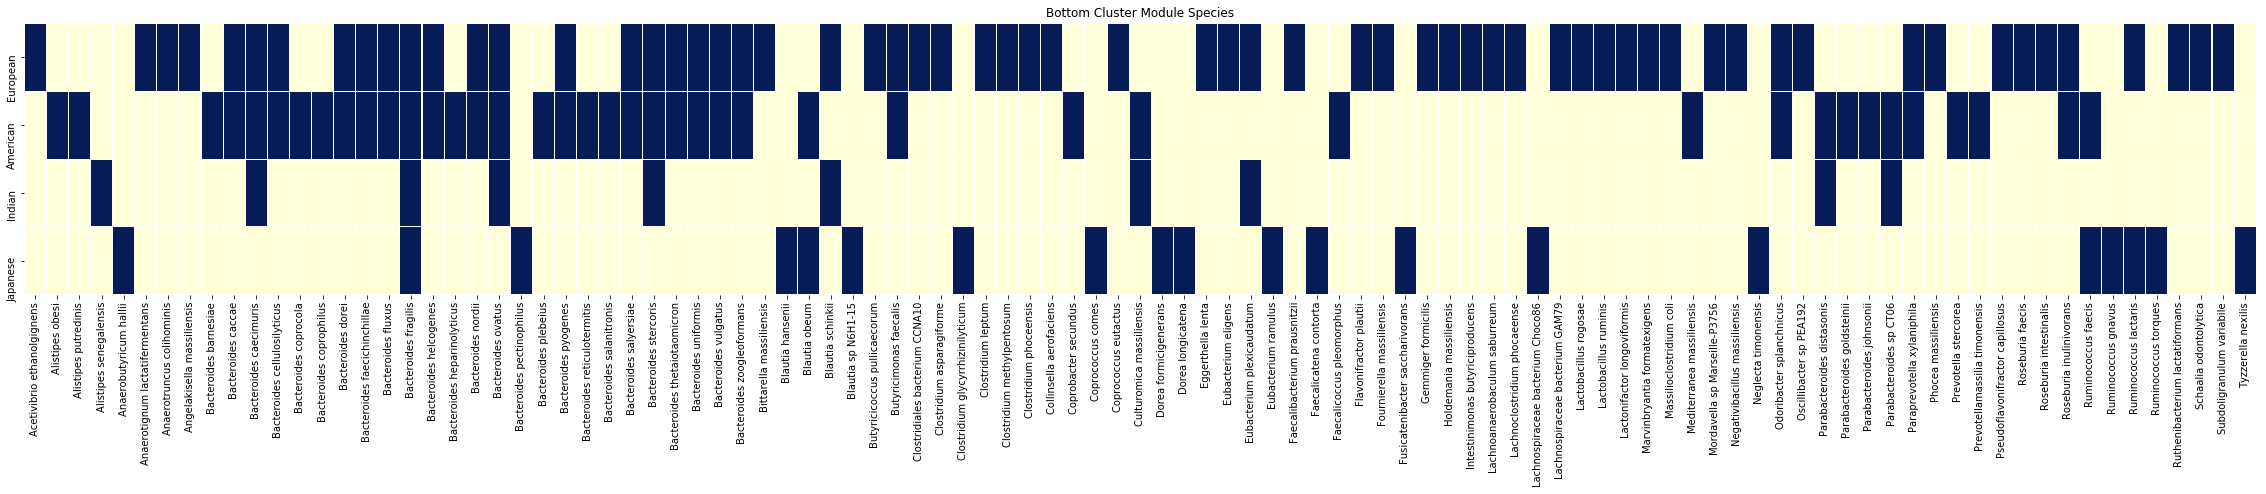

In [46]:
fig, ax = plt.subplots(figsize=(40,5))
sns.heatmap(BottomSpecies.T,xticklabels=1, yticklabels=1, linewidths=.05, cmap="YlGnBu", cbar=False)
plt.title("Bottom Cluster Module Species")

Text(0.5,1,'Bottom Cluster Module Genera')

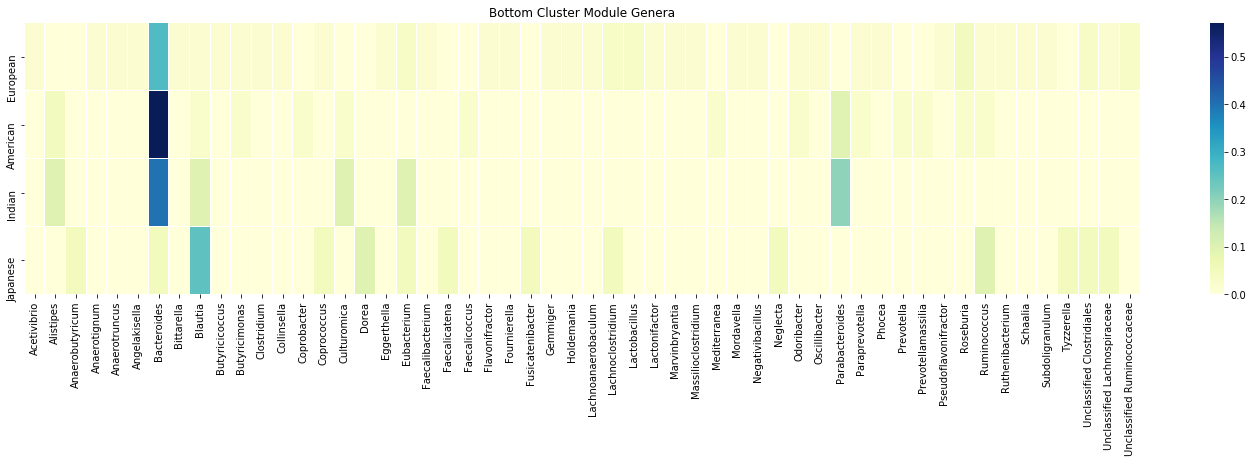

In [47]:
fig, ax = plt.subplots(figsize=(25,5))
sns.heatmap(BottomGenera.T,xticklabels=1, yticklabels=1, linewidths=.05, cmap="YlGnBu")
plt.title("Bottom Cluster Module Genera")

Text(0.5,1,'Top Cluster Module Species')

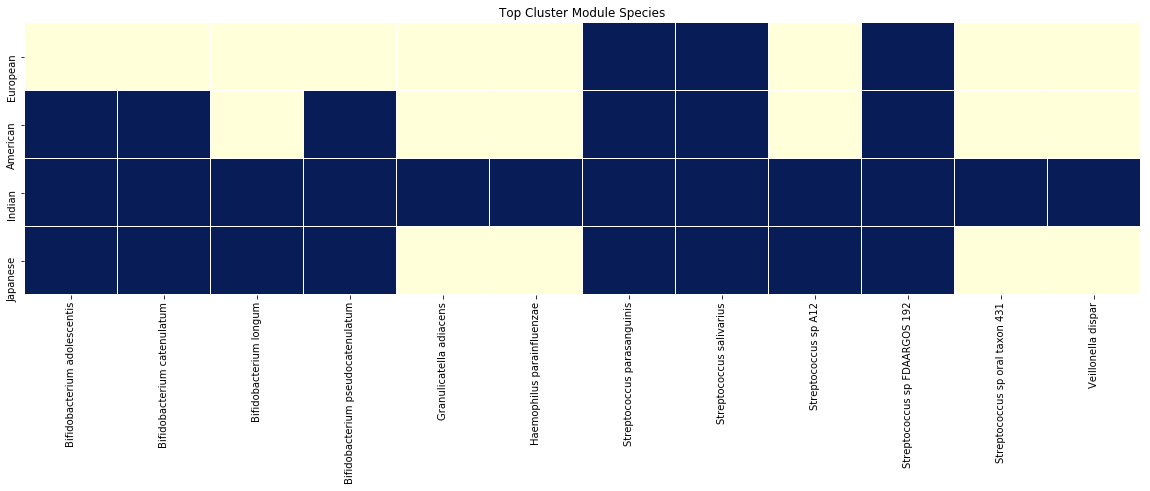

In [48]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(TopSpecies.T,xticklabels=1, yticklabels=1, linewidths=.05, cmap="YlGnBu", cbar=False)
plt.title("Top Cluster Module Species")

Text(0.5,1,'Top Cluster Module Genera')

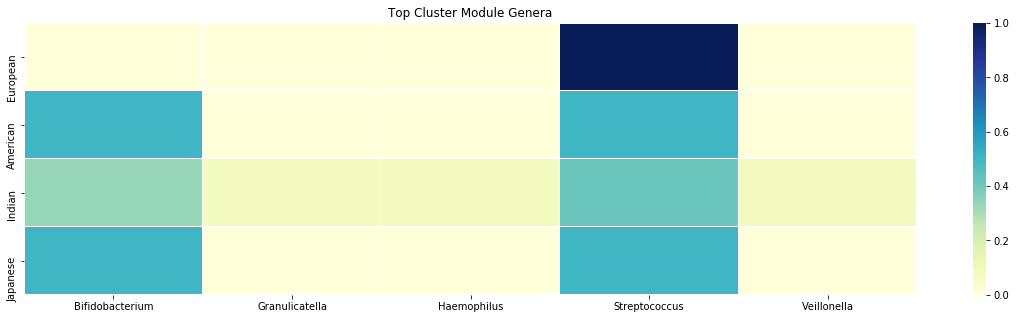

In [49]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(TopGenera.T,xticklabels=1, yticklabels=1, linewidths=.05, cmap="YlGnBu")
plt.title("Top Cluster Module Genera")

Text(0.5,1,'Left Cluster Module Species')

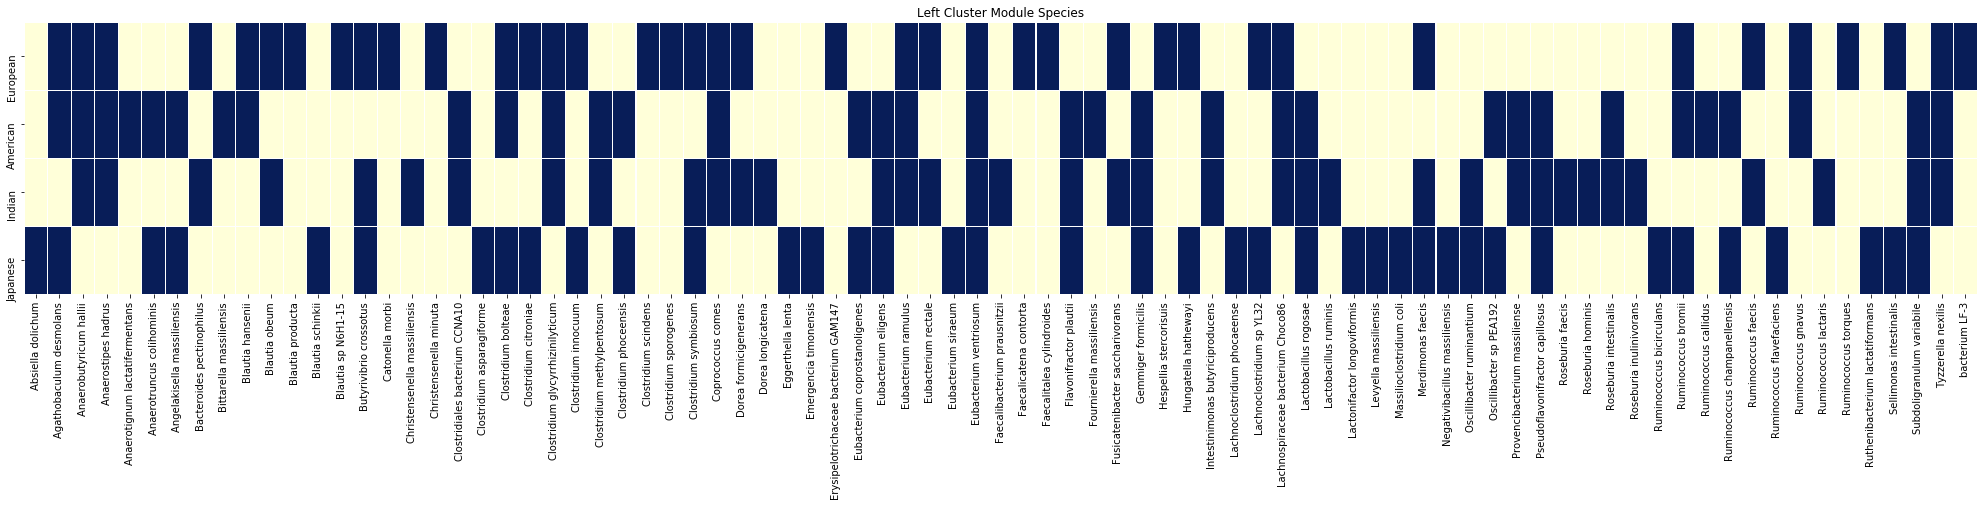

In [50]:
fig, ax = plt.subplots(figsize=(35,5))
sns.heatmap(LeftSpecies.T,xticklabels=1, yticklabels=1, linewidths=.05, cmap="YlGnBu", cbar=False)
plt.title("Left Cluster Module Species")

Text(0.5,1,'Left Cluster Module Genera')

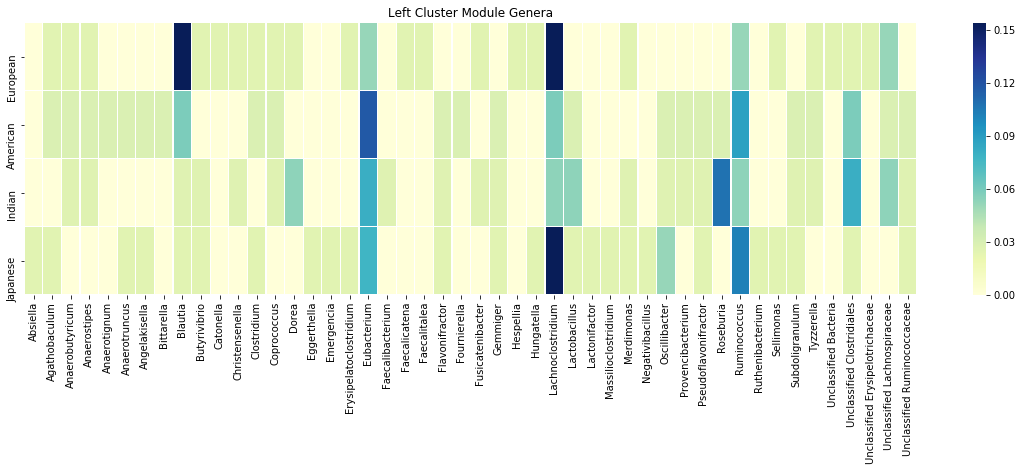

In [51]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(LeftGenera.T,xticklabels=1, yticklabels=1, linewidths=.05, cmap="YlGnBu")
plt.title("Left Cluster Module Genera")

Text(0.5,1,'Right Cluster Module Species')

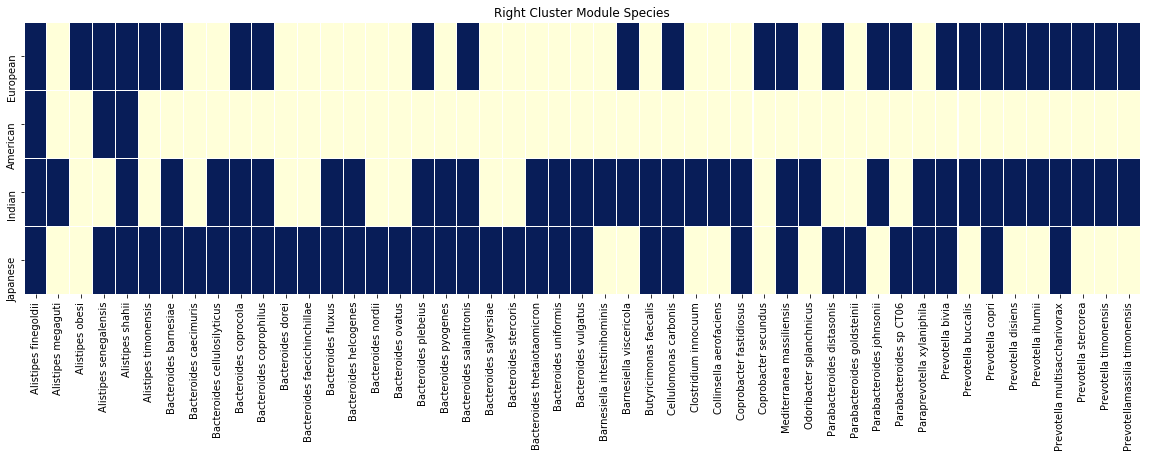

In [52]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(RightSpecies.T,xticklabels=1, yticklabels=1, linewidths=.05, cmap="YlGnBu", cbar=False)
plt.title("Right Cluster Module Species")

Text(0.5,1,'Right Cluster Module Genera')

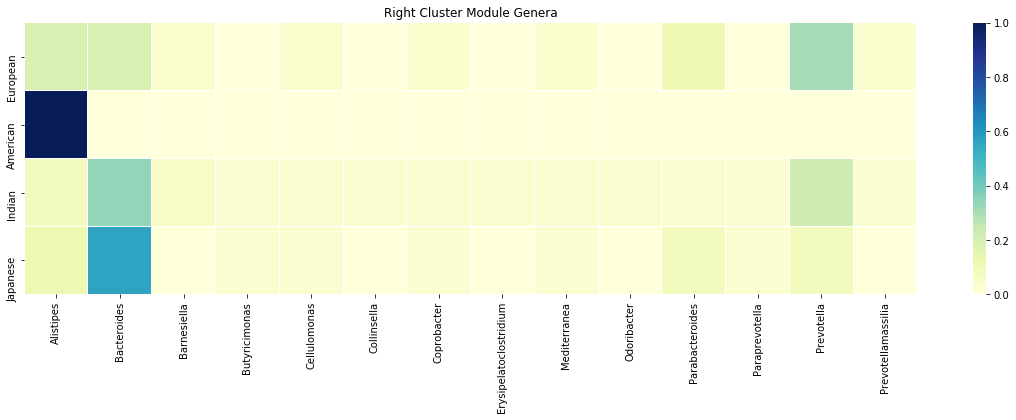

In [53]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(RightGenera.T,xticklabels=1, yticklabels=1, linewidths=.05, cmap="YlGnBu")
plt.title("Right Cluster Module Genera")

In [54]:
ModuleClassiferDF = allMDF3.copy()
ModuleClassiferDF['Cluster'] = 'temp'
for module in ModuleClassiferDF.index:
    if module in list(leftClusterModules.index):
        ModuleClassiferDF.at[module,"Cluster"] = 'Left_Cluster'
    elif module in list(topClusterModules.index):
        ModuleClassiferDF.at[module,"Cluster"] = 'Top_Cluster'
    elif module in list(rightClusterModules.index):
        ModuleClassiferDF.at[module,"Cluster"] = 'Right_Cluster'
    elif module in list(bottomClusterModules.index):
        ModuleClassiferDF.at[module,"Cluster"] = 'Bottom_Cluster'
    else:
        ModuleClassiferDF.at[module,"Cluster"] = 'ErrorNotClassfied'

In [55]:
ModuleClassiferDF = allMDF3.copy()
ModuleClassiferDF['Cluster'] = 'temp'
for module in ModuleClassiferDF.index:
    if module in list(leftClusterModules.index):
        ModuleClassiferDF.at[module,"Cluster"] = 'Left_Cluster'
    elif module in list(topClusterModules.index):
        ModuleClassiferDF.at[module,"Cluster"] = 'Top_Cluster'
    elif module in list(rightClusterModules.index):
        ModuleClassiferDF.at[module,"Cluster"] = 'Right_Cluster'
    elif module in list(bottomClusterModules.index):
        ModuleClassiferDF.at[module,"Cluster"] = 'Bottom_Cluster'
    else:
        ModuleClassiferDF.at[module,"Cluster"] = 'ErrorNotClassfied'

In [56]:
ModuleClassiferDF_noCohort = ModuleClassiferDF.drop(columns=['Cohort']).copy()
ModuleClassiferDF_noCohort.index.name =' Modules'
#ModuleClassiferDF_noCohort.to_csv("./DataFiles/GGM/ModuleClusterDF.csv")
ModuleClassiferDF_noCohort.head()

,TIGR02778,TIGR00283,TIGR02100,TIGR02359,TIGR00224,TIGR00745,TIGR00260,TIGR04171,TIGR03819,TIGR01419,...,TIGR01673,TIGR02366,TIGR01919,TIGR01832,TIGR00100,TIGR01295,TIGR03494,TIGR01733,TIGR00967,Cluster
Modules,,,,,,,,,,,,,,,,,,,,,
American_Module_0,-11.457902,-11.457902,4.771125,5.804750,8.424359,8.130302,8.241246,-11.457902,-11.457902,-11.457902,...,-11.457902,3.520843,-11.457902,-11.457902,5.932877,-11.457902,-11.457902,7.732213,8.424596,Bottom_Cluster
American_Module_1,-8.559897,7.626477,8.355151,9.075029,8.807405,9.061788,10.054659,-8.559897,-8.559897,-8.559897,...,-8.559897,8.726962,-8.559897,7.654709,-8.559897,-8.559897,-8.559897,-8.559897,9.741570,Left_Cluster
American_Module_2,-9.518060,-9.518060,7.337154,8.725481,8.704787,8.580210,9.059977,-9.518060,-9.518060,-9.518060,...,-9.518060,6.715446,-9.518060,-9.518060,-9.518060,-9.518060,-9.518060,9.481659,8.961949,Left_Cluster
American_Module_3,-5.886687,-5.886687,-5.886687,-5.886687,-5.886687,-5.886687,11.371535,11.371535,-5.886687,-5.886687,...,-5.886687,-5.886687,-5.886687,-5.886687,-5.886687,10.375734,-5.886687,11.371535,11.371535,Top_Cluster
American_Module_4,-4.510926,-4.510926,13.961113,-4.510926,-4.510926,12.853375,13.267966,12.853375,-4.510926,-4.510926,...,-4.510926,-4.510926,13.267966,-4.510926,-4.510926,-4.510926,-4.510926,-4.510926,13.267966,Top_Cluster


## Look at Networks

In [57]:
americanNetwork = nx.read_gexf("./DataFiles/GGM/Networks/americanNetwork.gexf")
indianNetwork = nx.read_gexf("./DataFiles/GGM/Networks/indianNetwork.gexf")
europeanNetwork = nx.read_gexf("./DataFiles/GGM/Networks/europeanNetwork.gexf")
japaneseNetwork = nx.read_gexf("./DataFiles/GGM/Networks/japaneseNetwork.gexf")

## Compare functional Distance to Association Strength

In [58]:
#ALL FUNCTION
from scipy.spatial import distance
def pullWeightDistance(network, cohortName, functionalDF):
    tempDict = {"Association_Weight":[], "Functional_Distance_TIGRFAM":[], "Cohort":[]}
    for i in list(network.edges(data='weight')):
        tempDict['Association_Weight'].append(float(i[2]))
        tempDict['Functional_Distance_TIGRFAM'].append(float(distance.braycurtis(np.array(functionalDF.loc[i[0].replace(",","").replace("(","").replace(")","")]), np.array(functionalDF.loc[i[1].replace(",","").replace("(","").replace(")","")]))))
        tempDict['Cohort'].append(cohortName)
    tempDF = pd.DataFrame(data=tempDict)
    return(tempDF)

In [59]:
afunctWeightDF = pullWeightDistance(americanNetwork, 'American', americanSF_tigr)
ifunctWeightDF = pullWeightDistance(indianNetwork, 'Indian', indianSF_tigr)
efunctWeightDF = pullWeightDistance(europeanNetwork, 'European', europeanSF_tigr)
jfunctWeightDF = pullWeightDistance(japaneseNetwork, 'Japanese', japaneseSF_tigr)

In [60]:
allFuntWeightDF = pd.concat([afunctWeightDF,ifunctWeightDF,efunctWeightDF,jfunctWeightDF]).copy()

In [61]:
from scipy import stats
slopeEuropean, Eintercept, Er_value, Ep_value, Estd_err = stats.linregress(allFuntWeightDF[allFuntWeightDF['Cohort']=='European']['Functional_Distance_TIGRFAM'],allFuntWeightDF[allFuntWeightDF['Cohort']=='European']['Association_Weight'])
slopeJapanese, Jintercept, Jr_value, Jp_value, Jstd_err = stats.linregress(allFuntWeightDF[allFuntWeightDF['Cohort']=='Japanese']['Functional_Distance_TIGRFAM'],allFuntWeightDF[allFuntWeightDF['Cohort']=='Japanese']['Association_Weight'])
slopeAmerican, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(allFuntWeightDF[allFuntWeightDF['Cohort']=='American']['Functional_Distance_TIGRFAM'],allFuntWeightDF[allFuntWeightDF['Cohort']=='American']['Association_Weight'])
slopeIndian, Iintercept, Ir_value, Ip_value, Istd_err = stats.linregress(allFuntWeightDF[allFuntWeightDF['Cohort']=='Indian']['Functional_Distance_TIGRFAM'],allFuntWeightDF[allFuntWeightDF['Cohort']=='Indian']['Association_Weight'])

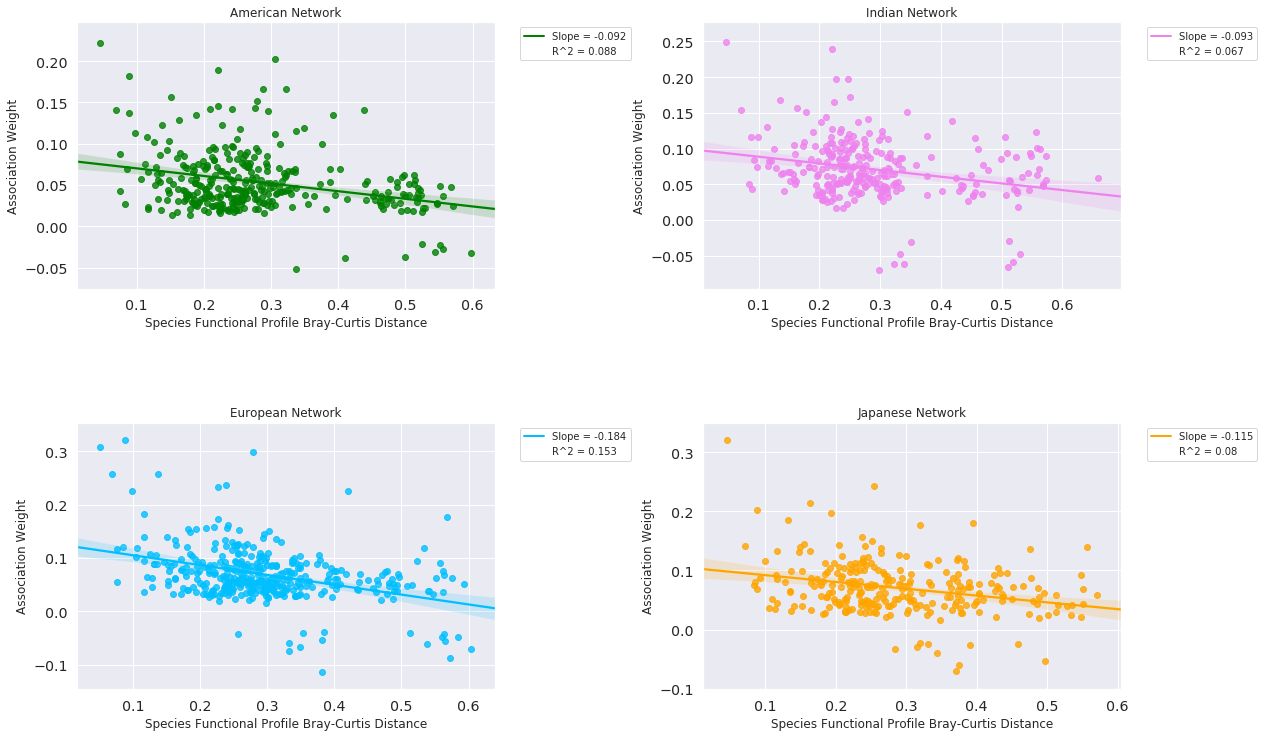

In [62]:
from matplotlib.lines import Line2D
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 18.7,12.27
fig, axs = plt.subplots(2, 2)

from scipy import stats

tips = sns.load_dataset("tips")

sns.regplot(ax=axs[0, 0], x="Functional_Distance_TIGRFAM", y="Association_Weight", data=allFuntWeightDF[allFuntWeightDF['Cohort']=='American'], color=palette['American'])
sns.regplot(ax=axs[0, 1], x="Functional_Distance_TIGRFAM", y="Association_Weight", data=allFuntWeightDF[allFuntWeightDF['Cohort']=='Indian'],color=palette['Indian'])
sns.regplot(ax=axs[1, 0], x="Functional_Distance_TIGRFAM", y="Association_Weight", data=allFuntWeightDF[allFuntWeightDF['Cohort']=='European'],color=palette['European'])
sns.regplot(ax=axs[1, 1], x="Functional_Distance_TIGRFAM", y="Association_Weight", data=allFuntWeightDF[allFuntWeightDF['Cohort']=='Japanese'],color=palette['Japanese'])

fig.subplots_adjust(hspace=.5, wspace=.5)

axs[0, 0].set_title("American Network", size=12)
# plot legend
legend_elementsA = [Line2D([0], [0], color=palette['American'], lw=2, label='Slope = '+str(float("{0:.3f}".format(slopeAmerican)))),
                   Line2D([0], [0], marker='o', color='w', label='R^2 = '+str(float("{0:.3f}".format(Ar_value**2))),
                          markerfacecolor='g', markersize=0)]                
axs[0, 0].legend(facecolor='white', handles=legend_elementsA, bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 10})
                          
axs[0, 0].set_ylabel('Association Weight', size=12)
axs[0, 0].set_xlabel('Species Functional Profile Bray-Curtis Distance', size=12)



legend_elementsI = [Line2D([0], [0], color=palette['Indian'], lw=2, label='Slope = '+str(float("{0:.3f}".format(slopeIndian)))),
                   Line2D([0], [0], marker='o', color='w', label='R^2 = '+str(float("{0:.3f}".format(Ir_value**2))),
                          markerfacecolor='g', markersize=0)]
axs[0, 1].set_title("Indian Network", size=12)
axs[0, 1].legend(facecolor='white', handles=legend_elementsI, bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 10})
axs[0, 1].set_ylabel('Association Weight', size=12)
axs[0, 1].set_xlabel('Species Functional Profile Bray-Curtis Distance', size=12)


legend_elementsE = [Line2D([0], [0], color=palette['European'], lw=2, label='Slope = '+str(float("{0:.3f}".format(slopeEuropean)))),
                   Line2D([0], [0], marker='o', color='w', label='R^2 = '+str(float("{0:.3f}".format(Er_value**2))),
                          markerfacecolor='g', markersize=0)]
axs[1, 0].set_title("European Network", size=12)
axs[1, 0].legend(facecolor='white', handles=legend_elementsE, bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 10})
axs[1, 0].set_ylabel('Association Weight', size=12)
axs[1, 0].set_xlabel('Species Functional Profile Bray-Curtis Distance', size=12)



legend_elementsJ = [Line2D([0], [0], color=palette['Japanese'], lw=2, label='Slope = '+str(float("{0:.3f}".format(slopeJapanese)))),
                   Line2D([0], [0], marker='o', color='w', label='R^2 = '+str(float("{0:.3f}".format(Jr_value**2))),
                          markerfacecolor='w', markersize=1)]

axs[1, 1].set_title("Japanese Network", size=12)
axs[1, 1].legend(facecolor='white', handles=legend_elementsJ, bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 10})
axs[1, 1].set_ylabel('Association Weight', size=12)
axs[1, 1].set_xlabel('Species Functional Profile Bray-Curtis Distance', size=12)
plt.show()

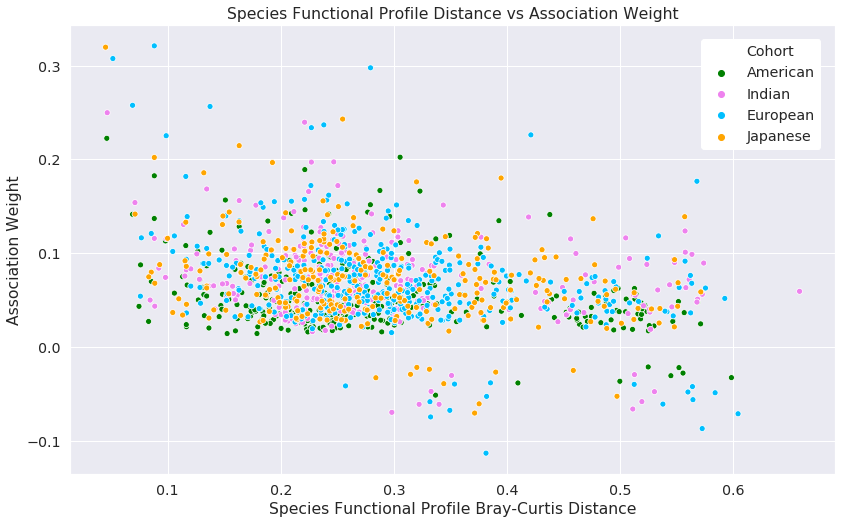

In [63]:
from matplotlib import rcParams
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 13.7,8.27
palette ={"American":'green', "European":'deepskyblue', "Indian":'violet', "Japanese":'orange'}

#palette ={"American":"C0","Indian":"C1", "European":"C3",'Japanese':'C2'}
sns.scatterplot(data=allFuntWeightDF, x='Functional_Distance_TIGRFAM', y='Association_Weight', hue='Cohort',palette=palette)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc=0, borderaxespad=1, facecolor='white', framealpha=1, edgecolor='white')

plt.title("Species Functional Profile Distance vs Association Weight")
plt.xlabel("Species Functional Profile Bray-Curtis Distance")
plt.ylabel("Association Weight")
plt.show()